# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21

In [3]:
# from fastai.text import *
from enum import Enum
import torch

In [4]:
import numpy as np
import torch.nn as nn

In [5]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [6]:
import sys
sys.path.insert(0, '../../')
from src.fastai_data import *
from src.encode_data import *
from src.serve import *

In [7]:
from src.music_transformer import *

In [8]:
from src.unilm import *

In [9]:
config = unilm_config(vocab)

In [10]:
# config = unilm_m_config(vocab)

In [11]:
# # config['n_layers'] = 8
# # config['dec_layers'] = 0
# config['n_layers'] = 2
# config['dec_layers'] = 2
# config['mem_len'] = 512
# config['rand_bptt'] = False
# config['bptt'] = 512
# config['bs'] = 8


In [12]:
config

{'ctx_len': 150,
 'n_layers': 8,
 'n_heads': 8,
 'd_model': 512,
 'd_head': 64,
 'd_inner': 2048,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'pad_idx': 1,
 'bos_idx': 0,
 'sep_idx': 8,
 'transpose_range': (0, 12),
 'rand_transpose': True,
 'rand_bptt': False,
 'note_range': (9, 137),
 'bs': 16,
 'bptt': 256,
 'vocab_size': 312,
 'dec_layers': 8}

In [13]:
base_path = Path('../../data/midi/v17/sf4/')

In [14]:
cache_name = 'tmp/hook_c'
# cache_name = 'tmp/sample'

## BERT Dataloading

In [15]:
ns_dl_tfms = [mask_tfm, next_sentence_tfm]
ns_config = config.copy()
ns_config['bs'] *= 2
ns_data = load_music_data(base_path/'piano_duet', cache_name=cache_name, vocab=vocab, 
                          y_offset=0, dl_tfms=ns_dl_tfms, **ns_config)

In [16]:
xb,yb = ns_data.one_batch(); [x.shape for x in xb+yb]

[torch.Size([32, 256]),
 torch.Size([32, 256]),
 torch.Size([32, 256]),
 torch.Size([32, 256])]

## S2S Dataloading

In [17]:
s2s_dl_tfms = [s2s_tfm]
s2s_data = MusicDataBunch.load(base_path/'s2s_encode', cache_name=cache_name, 
                           preloader_cls=S2SPreloader, dl_tfms=s2s_dl_tfms, y_offset=1,
                           shuffle_dl=True, **config)


In [18]:
s2s_data.train_dl.dl.dataset.on_epoch_begin()
s2s_data.train_dl.dl.dataset.on_epoch_end()
xb,yb = s2s_data.one_batch(); [x.shape for x in xb+yb]

[torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256])]

### Load NextWord dataset (Language Model)

In [19]:

nw_data = MusicDataBunch.load(base_path/'piano_duet', cache_name=cache_name, 
                              vocab=vocab, dl_tfms=[nw_tfm], y_offset=1, 
                              train_tfms=[to_single_stream], valid_tfms=[to_single_stream], **config)
nw_data.vocab = vocab

## Datasets

In [20]:
dbs = [nw_data, s2s_data, ns_data]
# datasets = [nw_data]

In [21]:
# datasets = [iter(range(10)), iter(range(20,100)), iter(range(200,240))]
datasets = [range(10), range(20,100), range(200,240)]

In [22]:
class CombinedDS(Callback):
    def __init__(self, dss):
        self.dss = self.dss
    def __getattr__(self, attr):
        def redirected(self, *args, **kwargs):
            for ds in self.dss:
                if hasattr(ds, attr):
                    getattr(ds, attr)(*args, **kwargs)
        return redirected

class CombinedDL():
    def __init__(self, dls, num_it=100):
        self.dls = dls
        self.dataset = CombinedDS([dl.dataset for dl in dls if hasattr(dl, 'dataset')])
        self.num_it = num_it
    def __len__(self)->int: return sum([len(dl) for dl in self.dls])
        
    def __iter__(self):
        "Process and returns items from `DataLoader`."
        iters = [iter(dl) for dl in self.dls]
        dl_idx = -1
        while len(iters):
            dl_idx = (dl_idx+1) % len(iters)
            for b in range(self.num_it):
                try:
                    yield next(iters[dl_idx])
                except StopIteration as e:
                    iters.remove(iters[dl_idx])
                    break
#         raise StopIteration

class CombinedData():
    def __init__(self, dbs, num_it=100):
        self.dbs = dbs
        self.train_dl = CombinedDL([db.train_dl for db in self.dbs], num_it)
        self.valid_dl = CombinedDL([db.valid_dl for db in self.dbs], num_it)
        
        self.train_ds = None
        self.path = dbs[0].path
        self.device = dbs[0].device
        self.empty_val = False

    def add_tfm(self,tfm:Callable)->None:
        for dl in self.dbs: dl.add_tfm(tfm)

    def remove_tfm(self,tfm:Callable)->None:
        for dl in self.dbs: dl.remove_tfm(tfm)
        

In [23]:
cdb = CombinedData(dbs)

In [24]:
cdl = CombinedDL(datasets)

In [25]:
len(cdl)

130

In [26]:
# for x in iter(cdl):
#     print(x)

## Load

In [27]:
def predict_func(parts): return [p if idx == 1 else F.softmax(p, dim=-1) for idx,p in enumerate(parts)]
# Need to monkey patch pred_batch activation function for 2d array
loss_func_name = camel2snake(BertLoss.__name__)
basic_train.loss_func_name2activ[loss_func_name] = predict_func

In [28]:
loss_func = BertLoss(loss_mult=(1,1,1,1))
learn = bert_model_learner(cdb, config.copy(), 
                           loss_func=loss_func)
# learn = bert_model_learner(datasets[0], config.copy(), 
#                            loss_func=loss_func)

# model = get_bert_model(config['vocab_size'], config=config.copy())
# learn = BertLearner(datasets[0], model, config=config, split_func=None, loss_func=loss_func)

In [29]:
learn.metrics = [mask_acc, nw_acc, s2s_acc, ns_acc]

In [30]:
from fastai.callbacks.rnn import RNNTrainer
learn.callbacks = [c for c in learn.callbacks if not isinstance(c, RNNTrainer)]
learn.callbacks.append(BertTrainer(learn))

In [31]:
[type(c) for c in learn.callbacks]

[src.unilm.BertTrainer]

In [32]:
learn.data

In [33]:
learn = learn.to_fp16()

### Training

In [35]:
learn.validate()

[12.591105, tensor(0.0971), tensor(0.), tensor(0.), tensor(0.0232)]

In [40]:
learn.fit_one_cycle(12, 1e-4)

TypeError: unsupported operand type(s) for +: 'int' and 'list'

## Load existing

In [29]:
base_path/'models/unilm'

PosixPath('../../data/midi/v17/sf4/models/unilm')

In [30]:
saved_models = get_files(base_path/'piano_duet/models/unilm', recurse=True, extensions=['.pth']); saved_models

[PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hq/4_ep90_best.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hq/4_ep90.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hq/5_ep40_reencode_best.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hq/3_ep30_full_best.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hq/3_ep30_full.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hq/5_ep40_reencode.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hook_c/5_ep40_reencode_best.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hook_c/1_ep60.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hook_c/6_ep40_reencode.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hook_c/6_ep40_reencode_best.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hook_c/1_ep60_best.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/m

In [31]:
load_path = saved_models[8]
state = torch.load(load_path, map_location='cpu')
get_model(learn.model).load_state_dict(state['model'], strict=False)
load_path

PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hook_c/6_ep40_reencode.pth')

## Prediction

Prediction algo

In [32]:
csv_path = base_path/f'piano_duet/piano_duet.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

# keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('la-bamba')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results.head()

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,9,10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,section,ht_key,song_url,midi,artist,md5,numpy,ht_offset,title,midi_title,parts,genres,mxl,source,ht_mode,ht_time_signature,ht_bpm
193208,chorus,C,https://www.hooktheory.com/theorytab/view/ritc...,midi_sources/hooktheory/pianoroll/r/ritchie-va...,ritchie-valen,aeee134e4034e5f98bb630c56d2f7f8c,sf4/piano_duet/hooktheory/pianoroll/r/ritchie-...,0.0,la-bamba,La Bamba,chorus,"Pop,Rock",NaN,hooktheory_c,1.0,4.0,144.0


In [33]:
idx = 0
file = base_path.parent/results.numpy.values[idx];
orig = base_path.parent/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v17/sf4/piano_duet/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v17/midi_sources/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.mid'))

In [34]:
seed_len = 40
song_np = np.load(file)
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(to_single_stream(seed_np, vocab=vocab))[None]
if torch.cuda.is_available(): xb = xb.cuda()

In [35]:
# seed_stream = npenc2stream(seed_np)
# seed_stream.show()

In [36]:
xb

tensor([[  0,   1,   8, 147,  64, 139,   8, 139,  66, 139,   8, 139,  68, 139,
           8, 139,  69, 141,  64, 145,  61, 145,  57, 145,   8, 141,  73, 139,
           8, 139,  76, 139,   8, 139,  74, 139,  69, 145,  66, 145,  62, 145,
           8, 139,  74, 139,   8, 139,  78, 139,   8, 139,  76, 141,   8, 139,
          59, 145,  56, 145,  52, 145,   8, 139,  64, 139,   8, 139,  68, 139,
           8, 139,  71, 139,   8, 139,  74, 139,  69, 145,  66, 145]],
       device='cuda:0')

In [37]:
# task_type = torch.full_like(xb, TaskType.NextWord.value)

# learn.model.reset()

# res = learn.pred_batch(batch=((xb,task_type,xb),xb)); res

# preds = loss_batch(learn.model.eval(), (xb,task_type,xb), yb); preds

In [38]:
# last = res[-1][0, -1]; last[143]
# idx = torch.multinomial(res[-1][0, -1], 1).item(); idx

In [39]:

def predict_nw(self, xb:Tensor, n_words:int=128,
                 temperatures:float=(1.0,1.0), min_bars=4,
                 top_k=40, top_p=0.9):
    "Return the `n_words` that come after `text`."
    self.model.reset()
    self.model.update_mem_len(TaskType.NextWord.value)
    if xb.shape[0] > 1: xb = xb[0][None]
    seed = xb.cpu().numpy().squeeze()
    yb = torch.ones_like(xb)
    new_idx = []

    sep_count = 0

    bar_len = SAMPLE_FREQ * 4 # assuming 4/4 time
    vocab = self.data.vocab

    with torch.no_grad():
        for i in progress_bar(range(n_words), leave=True):
            task_type = torch.full_like(xb, TaskType.NextWord.value)

            res = self.pred_batch(batch=((xb,task_type,xb),yb))[-1][0, -1]

            # bar = 16 beats
            if (sep_count // 16) <= min_bars: res[vocab.bos_idx] = 0.

            # Use first temperatures value if last prediction was duration
            temperature = temperatures[0] if (len(new_idx)==0 or self.data.vocab.is_duration(new_idx[-1])) else temperatures[1]
            if temperature != 1.: res.pow_(1 / temperature)

            res = top_k_top_p_filtering(res, top_k=top_k, top_p=top_p, filter_value=0)
            idx = torch.multinomial(res, 1).item()

            if new_idx and new_idx[-1]==vocab.sep_idx: 
                duration = idx - vocab.dur_range[0]
                sep_count += duration
                # print('Bars', duration, sep_count // 16)

            if idx==vocab.bos_idx: 
                print('Predicted BOS token. Returning prediction...')
                break


            new_idx.append(idx)
            xb = xb.new_tensor([idx])[None]
    return np.array(new_idx), seed

In [40]:
out_s, seed_s = predict_nw(learn, xb, n_words=400)

In [41]:
vocab.textify(out_s)

'n53 d8 xxsep d2 n64 d2 xxsep d2 n62 d2 xxsep d2 n60 d2 xxsep d2 n60 d4 n55 d8 n52 d8 n48 d8 xxsep d4 n64 d2 xxsep d2 n67 d2 xxsep d2 n65 d2 n60 d8 n57 d8 n53 d8 xxsep d2 n65 d2 xxsep d2 n69 d2 xxsep d2 n72 d2 xxsep d2 n67 d2 n50 d6 n47 d6 n43 d6 xxsep d2 n55 d2 xxsep d2 n59 d2 xxsep d2 n62 d2 n50 d2 n47 d2 n43 d2 xxsep d2 n65 d2 n60 d8 n57 d8 n53 d8 xxsep d2 n64 d2 xxsep d2 n62 d2 xxsep d2 n60 d2 xxsep d2 n60 d4 n55 d8 n52 d8 n48 d8 xxsep d4 n64 d2 xxsep d2 n67 d2 xxsep d2 n65 d2 n60 d8 n57 d8 n53 d8 xxsep d2 n65 d2 xxsep d2 n69 d2 xxsep d2 n67 d4 xxsep d2 n50 d8 n47 d8 n43 d8 xxsep d2 n55 d2 xxsep d2 n59 d2 xxsep d2 n62 d2 xxsep d2 n65 d2 n60 d8 n57 d8 n53 d8 xxsep d2 n64 d2 xxsep d2 n62 d2 xxsep d2 n60 d2 xxsep d2 n60 d4 n58 d8 n55 d8 n52 d8 n48 d8 xxsep d4 n64 d2 xxsep d2 n67 d2 xxsep d2 n65 d2 n60 d8 n57 d8 n53 d8 xxsep d2 n65 d2 xxsep d2 n69 d2 xxsep d2 n72 d2 xxsep d2 n67 d4 n52 d8 n48 d8 n43 d8 xxsep d4 n72 d4 xxsep d4 n67 d4 n53 d2 n50 d2 n47 d2 n43 d2 xxsep d6 n55 d2 xxsep d2

In [42]:
test_out = to_double_stream(out_s); test_out

array([[53,  8],
       [-1,  2],
       [64,  2],
       [-1,  2],
       ...,
       [43,  6],
       [-1,  2],
       [55,  2],
       [-1,  2]])

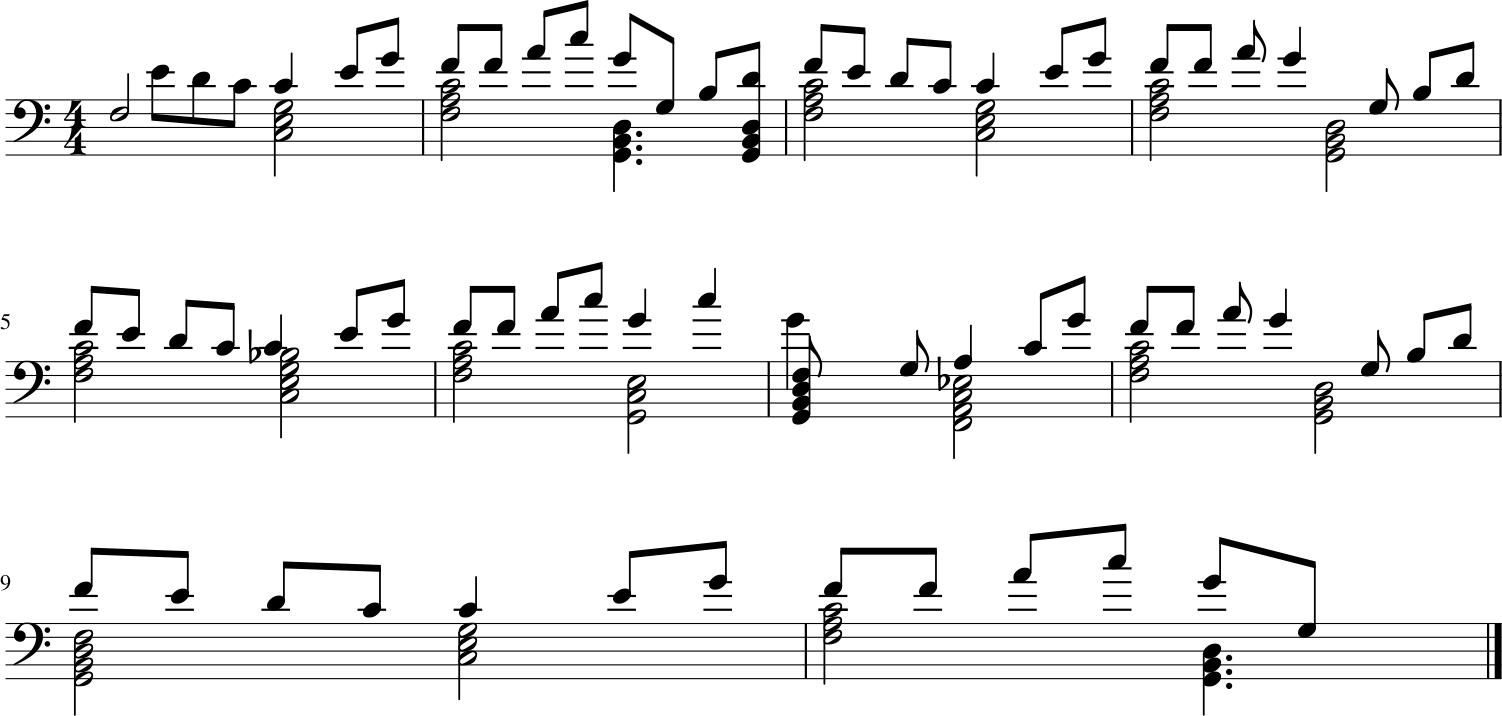

In [43]:
stream = npenc2stream(to_double_stream(out_s))
stream.show()

In [44]:
stream.show('midi')

## Predict Seq2Seq

In [60]:
csv_path = base_path/f's2s_encode/s2s_encode.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

# keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('tong-hua')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results.head()

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4,7,9,11,14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ht_mode,title,genres,source,section,midi,artist,parts,ht_bpm,midi_title,ht_time_signature,ht_key,ht_offset,md5,song_url,numpy,mxl
178790,1.0,tong-hua,"Electronic,Pop",hooktheory_c,chorus,midi_sources/hooktheory/pianoroll/g/guang-lian...,guang-liang,chorus,67.0,Tong Hua,4.0,C,0.0,2d80d686acf40368b07cf4a9099cb07e,https://www.hooktheory.com/theorytab/view/guan...,sf4/s2s_encode/hooktheory/pianoroll/g/guang-li...,NaN


In [61]:
idx = 0
file = base_path.parent/results.numpy.values[idx];
orig = base_path.parent/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v17/sf4/s2s_encode/hooktheory/pianoroll/g/guang-liang/tong-hua/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v17/midi_sources/hooktheory/pianoroll/g/guang-liang/tong-hua/chorus_key_cmajor.mid'))

In [62]:
from src.midi_data import *

In [63]:
file2stream(orig).show('midi')

In [64]:
melody_np, chord_np = np.load(file, allow_pickle=True)

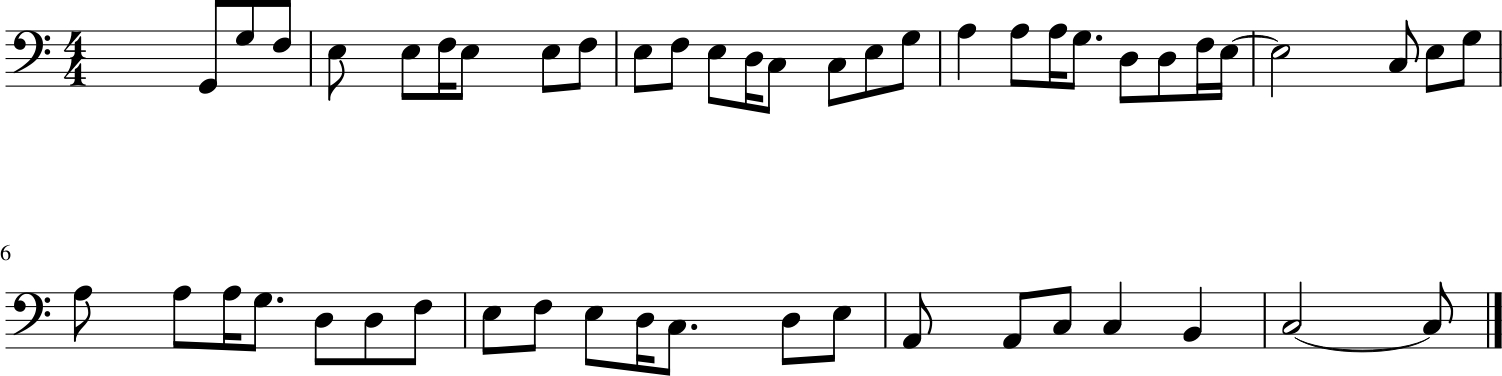

In [65]:
npenc2stream(melody_np).show()

In [66]:
m, c = s2s_file2parts(file, pred_melody=True)
xb = torch.tensor(c)[None].cuda()
yb = torch.tensor(m)[None].cuda()

In [67]:
# c, m = s2s_file2parts(file, pred_melody=False)
# xb = torch.tensor(c)[None].cuda()
# yb = torch.tensor(m)[None].cuda()

In [68]:
# yb_seed = yb[:,:3]
# pad = xb.shape[-1]-yb_seed.shape[-1]

In [69]:

def predict_s2s(self, xb:Tensor, yb:Tensor, n_words:int=128,
                temperatures:float=(1.0,1.0),
                top_k=40, top_p=0.9):
    if xb.shape[0] > 1: xb = xb[0][None]
    # yb_seed = yb[:, :5]
    yb_seed = yb
    self.model.reset()
    self.model.update_mem_len(TaskType.Seq2Seq.value)

    for i in progress_bar(range(n_words), leave=True):
        task_type = torch.full_like(xb, TaskType.Seq2Seq.value)
        pad = xb.shape[-1]-yb_seed.shape[-1]
        yb_inp = F.pad(yb_seed, (0,pad), value=vocab.pad_idx)

        # Next Word
        pred_idx = yb_seed.shape[-1]-1
        res = self.pred_batch(batch=((xb,task_type,yb_inp),yb_inp))[-1][0, pred_idx] # task1, task2 - (bs x ts x vocab)

        # Encoder only - nw
#         res = self.pred_batch(batch=((xb,task_type,xb),xb))[0][0, -1] # task1, task2 - (bs x ts x vocab)

        # Use first temperatures value if last prediction was duration
        temperature = temperatures[0] if (len(yb_seed)==0 or self.data.vocab.is_duration(yb_seed[0, -1])) else temperatures[1]
        if temperature != 1.: res.pow_(1 / temperature)

        res = top_k_top_p_filtering(res, top_k=top_k, top_p=top_p, filter_value=0)
        idx = torch.multinomial(res, 1).item()
        #         idx = res.argmax()

        if idx == vocab.bos_idx | idx == vocab.stoi[EOS]: 
            print('Predicting BOS/EOS')
            break

        t_idx = torch.tensor(idx, device=xb.device).view(1, 1)
        yb_seed = torch.cat((yb_seed, t_idx), dim=-1)

    return yb_seed

In [70]:
# yb_out = learn.predict_s2s(xb, yb, n_words=250)

In [71]:
yb_out = predict_s2s(learn, xb, yb[:,:30], n_words=250)

In [72]:
seed_npenc = to_double_stream(xb.cpu().numpy())
yb_npenc = to_double_stream(yb_out.cpu().numpy())

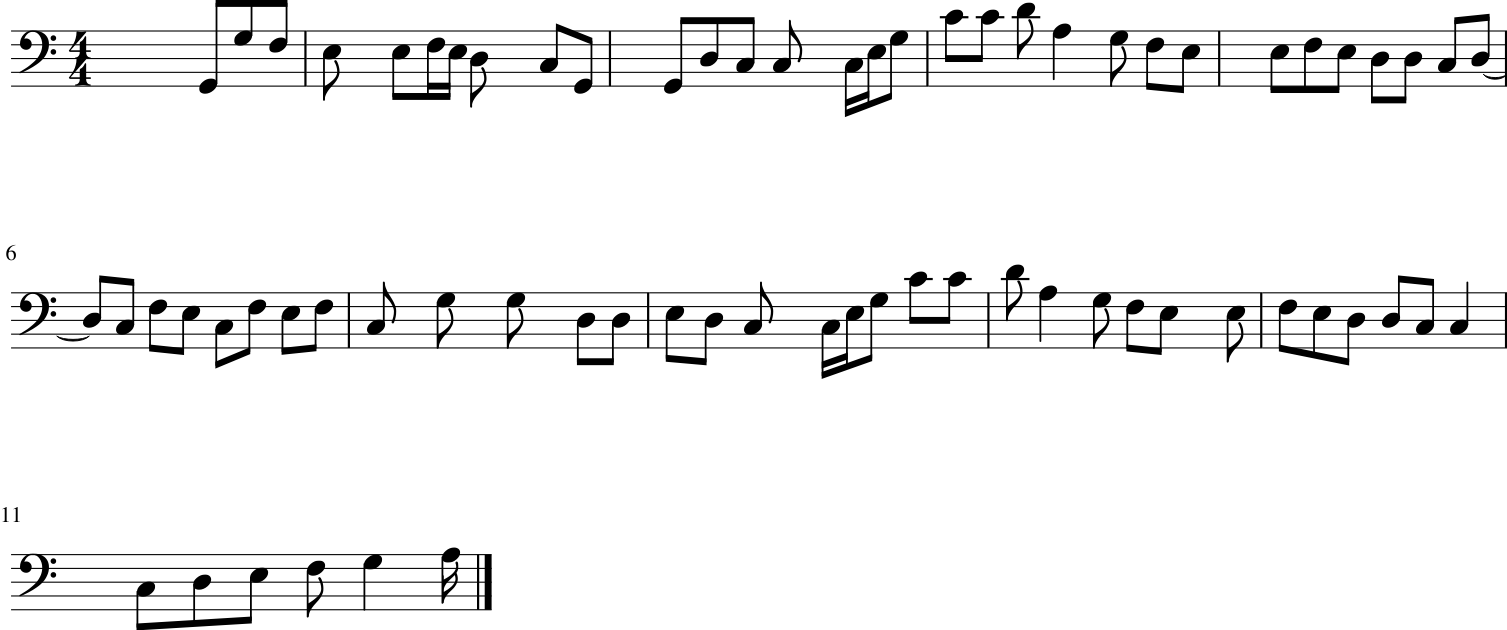

In [73]:
npenc2stream(yb_npenc).show()

In [74]:
npenc2stream(yb_npenc).show('midi')

In [75]:
# chordarr_comb = combined_npenc2chordarr(yb_test, melody_np)
chordarr_comb = combined_npenc2chordarr(yb_npenc, seed_npenc)

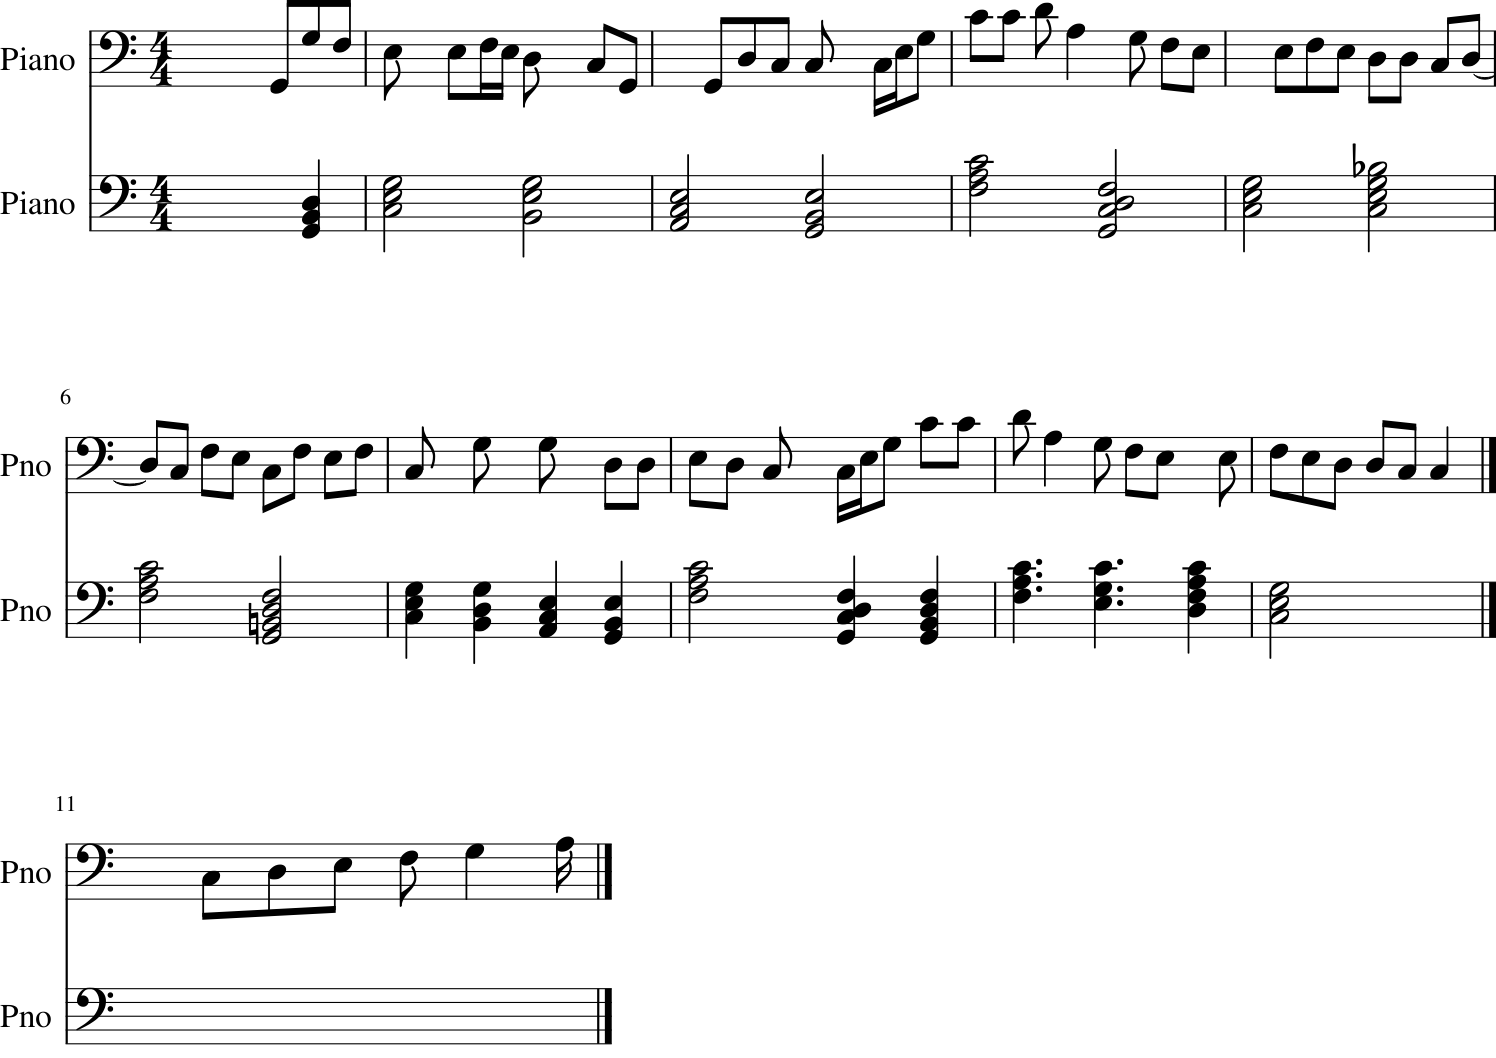

In [76]:
chordarr2stream(chordarr_comb, bpm=108).show()

In [77]:
chordarr2stream(chordarr_comb, bpm=108).show('midi')

In [78]:
max(1,2,3)

3

In [79]:

def part_enc(chordarr, part):
    partarr = chordarr[:,part:part+1,:]
    npenc = chordarr2npenc(partarr)
    return npenc
    
# NOTE: looks like npenc does not include the separator. 
# This means we don't have to remove the last (separator) step from the seed in order to keep predictions
def s2s_predict_from_midi(learn, midi=None, n_words=600, 
                      temperatures=(1.0,1.0), top_k=24, top_p=0.7, pred_melody=True, **kwargs):

    stream = file2stream(midi) # 1.
    chordarr = stream2chordarr(stream) # 2.
    _,num_parts,_ = chordarr.shape
    melody_np, chord_np = [part_enc(chordarr, i) for i in range(num_parts)]
    

    melody_np, chord_np = (melody_np, chord_np) if avg_pitch(melody_np) > avg_pitch(chord_np) else (chord_np, melody_np) # Assuming melody has higher pitch
    pred_melody=True
    
    offset = 3
    original_shape = melody_np.shape[0] * 2 if pred_melody else chord_np.shape[0] * 2 
#     original_shape = 20
    bptt = original_shape + n_words + offset
    bptt = max(bptt, melody_np.shape[0] * 2, chord_np.shape[0] * 2 )
    mpart = partenc2seq2seq(melody_np, part_type=MSEQ, translate=pred_melody, bptt=bptt)
    cpart = partenc2seq2seq(chord_np, part_type=CSEQ, translate=not pred_melody, bptt=bptt)

    xb = torch.tensor(cpart)[None]
    yb = torch.tensor(mpart)[None][:, :original_shape+offset]
    
    print('Input shapes:', xb.shape, yb.shape)
    # pred = learn.predict_s2s(xb, yb, n_words=n_words, temperatures=temperatures, top_k=top_k, top_p=top_p)
    pred = yb

    seed_npenc = to_double_stream(xb.cpu().numpy()) # chord
    yb_npenc = to_double_stream(pred.cpu().numpy()) # melody
    npenc_order = [yb_npenc, seed_npenc] if pred_melody else [seed_npenc, yb_npenc]
    chordarr_comb = combined_npenc2chordarr(*npenc_order)

    return chordarr_comb

In [82]:
out = s2s_predict_from_midi(learn, midi=orig); out[0].shape, out[1].shape

Input shapes: torch.Size([1, 795]) torch.Size([1, 195])


((2, 128), (2, 128))

In [88]:
chordarr2stream(out).write('midi', '/tmp/1234.mid')

'/tmp/1234.mid'

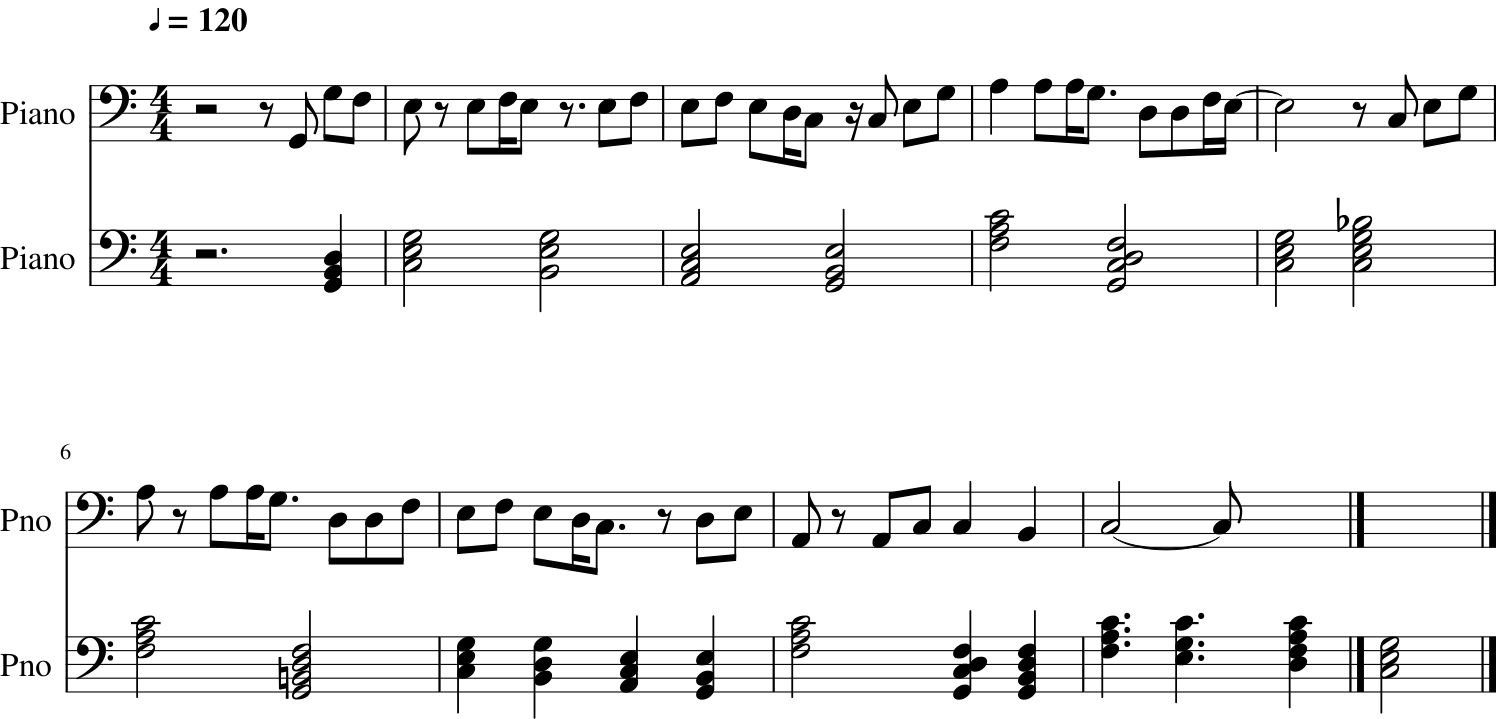

In [89]:
file2stream('/tmp/1234.mid').show()

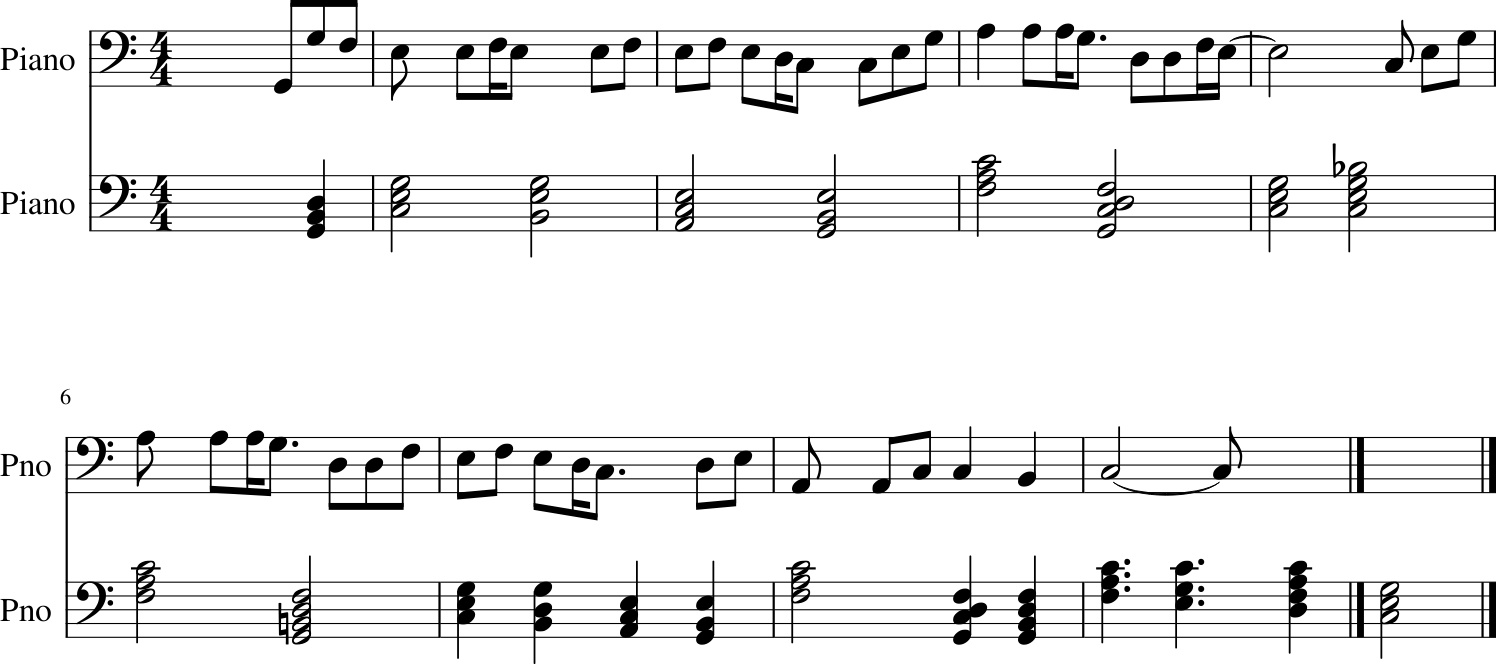

In [83]:
chordarr2stream(out).show()

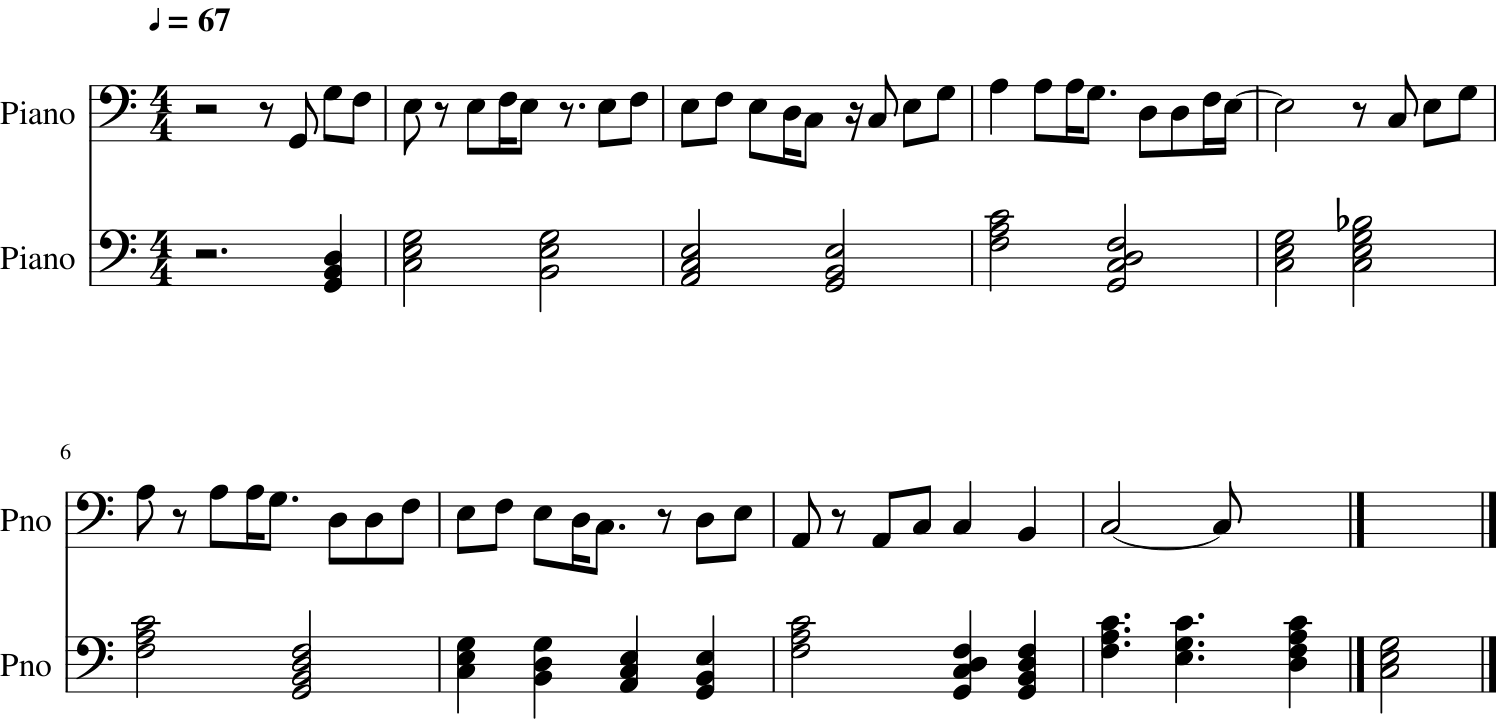

In [84]:
file2stream(orig).show()

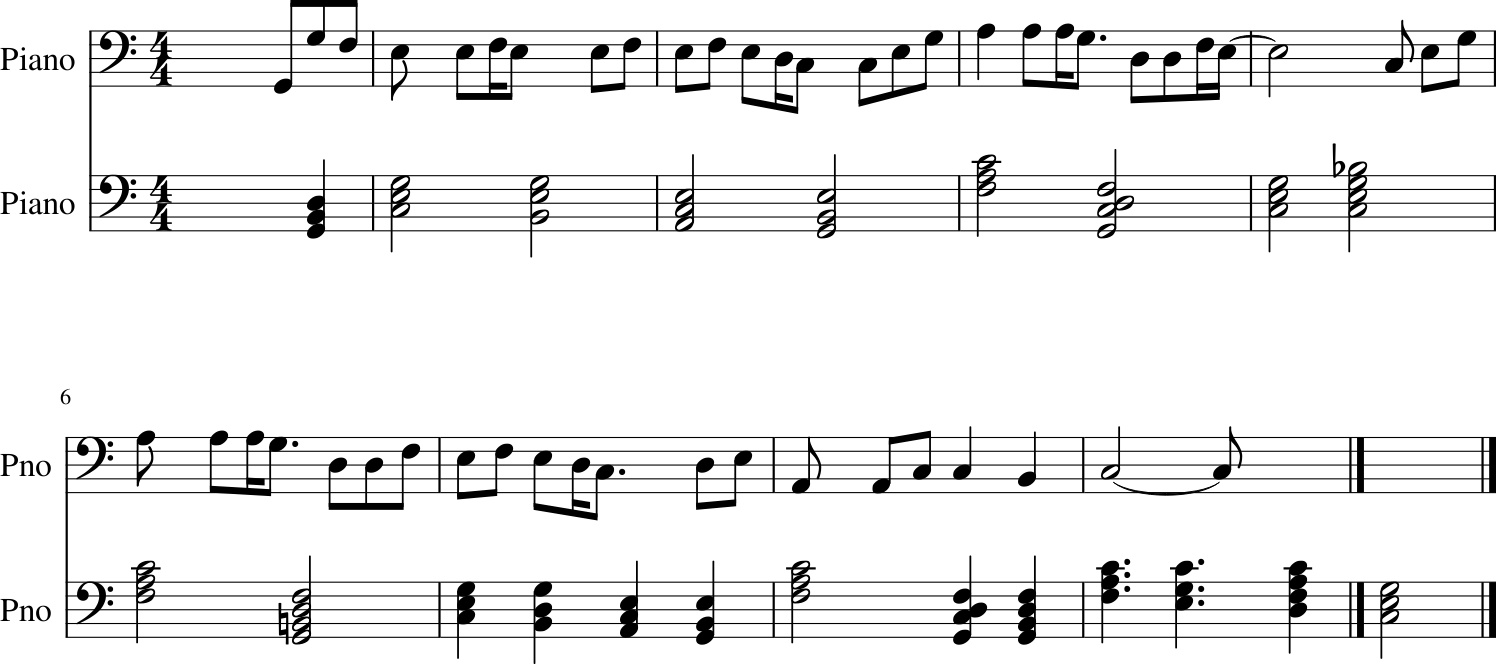

In [85]:
chordarr2stream(out).show()